<a href="https://colab.research.google.com/github/sainvo/DeepLearning_NER/blob/master/DL_NER_2_1_attempt_BERT_not_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning NER task

Tatjana Cucic and Sanna Volanen

https://spacy.io/api/annotation

# Milestones

## 1.1 Predicting word labels independently

* The first part is to train a classifier which assigns a label for each given input word independently. 
* Evaluate the results on token level and entity level. 
* Report your results with different network hyperparameters. 
* Also discuss whether the token level accuracy is a reasonable metric.









In [1]:
# Training data: Used for training the model
!wget https://raw.githubusercontent.com/sainvo/DeepLearning_NER/master/train.tsv

# Development/ validation data: Used for testing different model parameters, for example level of regularization needed
!wget https://raw.githubusercontent.com/sainvo/DeepLearning_NER/master/dev.tsv

# Test data: Never touched during training / model development, used for evaluating the final model
!wget https://raw.githubusercontent.com/sainvo/DeepLearning_NER/master/test.tsv

import sys 
import csv

csv.field_size_limit(sys.maxsize)

--2020-05-10 16:28:24--  https://raw.githubusercontent.com/sainvo/DeepLearning_NER/master/train.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17252156 (16M) [text/plain]
Saving to: ‘train.tsv’

train.tsv           100%[===================>]  16.45M  42.6MB/s    in 0.4s    

2020-05-10 16:28:25 (42.6 MB/s) - ‘train.tsv’ saved [17252156/17252156]

--2020-05-10 16:28:28--  https://raw.githubusercontent.com/sainvo/DeepLearning_NER/master/dev.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2419425 (2.3M) [text/plain]
Saving to: ‘dev.ts

131072

In [2]:
from collections import namedtuple
OneWord=namedtuple("OneWord",["word","entity_label"])

def read_ontonotes(tsv_file):
  #"""Yield complete sentences"""
    current_sentence=[] # list of (word,label) tuples
    with open(tsv_file) as f:
        tsvreader = csv.reader(f, delimiter= '\t')
        for line in tsvreader:
            #print(line)
            if not line: #sentence break
                if current_sentence: #if we gathered a sentence, we should yield it, because a new starts
                    yield current_sentence #much like return, but continues past this line once the element has been consumed
                    current_sentence=[] #...and start a new one
                continue
            #if we made it here, we are on a normal line
            columns=[line[0], line[1]] #an actual word line
            assert len(columns)==2 #we should have four columns, looking at the data
            current_sentence.append(OneWord(*columns)) #shorthand for looping over columns
        else: #for ... else -> the else part is executed once, when "for" runs out of elements
            if current_sentence: #yield also the last one!
                yield current_sentence

#read the data in as sentences
sentences_train=list(read_ontonotes("train.tsv"))
sentences_dev=list(read_ontonotes("dev.tsv"))
sentences_test = list(read_ontonotes("test.tsv"))

print(type(sentences_test))

print("First three sentences")
for sent in sentences_train[:3]:
    print(sent)
print(len(sentences_train))
print('---------------------------------------------')
print("First three sentences")
for sent in sentences_dev[:3]:
    print(sent)
print(len(sentences_dev))
print('---------------------------------------------')
print("First three sentences")
for sent in sentences_test[:3]:
    print(sent)
print(len(sentences_test))

<class 'list'>
First three sentences
[OneWord(word='Big', entity_label='O'), OneWord(word='Managers', entity_label='O'), OneWord(word='on', entity_label='O'), OneWord(word='Campus', entity_label='O')]
[OneWord(word='In', entity_label='O'), OneWord(word='recent', entity_label='B-DATE'), OneWord(word='years', entity_label='I-DATE'), OneWord(word=',', entity_label='O'), OneWord(word='advanced', entity_label='O'), OneWord(word='education', entity_label='O'), OneWord(word='for', entity_label='O'), OneWord(word='professionals', entity_label='O'), OneWord(word='has', entity_label='O'), OneWord(word='become', entity_label='O'), OneWord(word='a', entity_label='O'), OneWord(word='hot', entity_label='O'), OneWord(word='topic', entity_label='O'), OneWord(word='in', entity_label='O'), OneWord(word='the', entity_label='O'), OneWord(word='business', entity_label='O'), OneWord(word='community', entity_label='O'), OneWord(word='.', entity_label='O')]
[OneWord(word='With', entity_label='O'), OneWord(wor

In [0]:
# shape into dicts per sentence

def reshape_sent2dicts(f):
    data_dict = []
    for line in f:
        sent_text= [] 
        sent_tags = []
        for OneWord in line:
            #print(OneWord)
            sent_text.append(OneWord.word)
            sent_tags.append(OneWord.entity_label)
        sent_dict = {'text':sent_text,'tags':sent_tags }
        #print(sent_dict)
        data_dict.append(sent_dict)
    return data_dict

train_data = list(reshape_sent2dicts(sentences_train[:30000]))

dev_data = list(reshape_sent2dicts(sentences_dev))

In [4]:
import random
import numpy

random.seed(123)
random.shuffle(train_data)
print(type(train_data))
print(type(train_data[0]))

train_texts=[i["text"] for i in train_data]
train_labels=[i["tags"] for i in train_data]

print(type(train_texts))
print(type(train_texts[0]))

print('Text: ', train_texts[0])
print('Label: ', train_labels[0])

<class 'list'>
<class 'dict'>
<class 'list'>
<class 'list'>
Text:  ['Sharon', 'Repudiates', 'the', 'Road', 'Map', '.']
Label:  ['O', 'O', 'O', 'O', 'O', 'O']


In [0]:
## same for validation/dev data
dev_texts=[i["text"] for i in dev_data]
dev_labels=[i["tags"] for i in dev_data]

In [6]:
# Load pretrained embeddings
!wget -nc https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip


--2020-05-10 16:28:35--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 2606:4700:10::6816:4a8e, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  57.0MB/s    in 11s     

2020-05-10 16:28:47 (56.7 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [7]:
# Give -n argument so that a possible existing file isn't overwritten 
!unzip -n wiki-news-300d-1M.vec.zip

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [8]:
from gensim.models import KeyedVectors

vector_model = KeyedVectors.load_word2vec_format("wiki-news-300d-1M.vec", binary=False, limit=50000)


# sort based on the index to make sure they are in the correct order
words = [k for k, v in sorted(vector_model.vocab.items(), key=lambda x: x[1].index)]
print("Words from embedding model:", len(words))
print("First 50 words:", words[:50])

# Normalize the vectors to unit length
print("Before normalization:", vector_model.get_vector("in")[:10])
vector_model.init_sims(replace=True)
print("After normalization:", vector_model.get_vector("in")[:10])

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Words from embedding model: 50000
First 50 words: [',', 'the', '.', 'and', 'of', 'to', 'in', 'a', '"', ':', ')', 'that', '(', 'is', 'for', 'on', '*', 'with', 'as', 'it', 'The', 'or', 'was', "'", "'s", 'by', 'from', 'at', 'I', 'this', 'you', '/', 'are', '=', 'not', '-', 'have', '?', 'be', 'which', ';', 'all', 'his', 'has', 'one', 'their', 'about', 'but', 'an', '|']
Before normalization: [-0.0234 -0.0268 -0.0838  0.0386 -0.0321  0.0628  0.0281 -0.0252  0.0269
 -0.0063]
After normalization: [-0.0163762  -0.01875564 -0.05864638  0.02701372 -0.02246478  0.04394979
  0.01966543 -0.0176359   0.01882563 -0.00440898]


In [9]:
# Build vocabulary mappings

# Zero is used for padding in Keras, prevent using it for a normal word.
# Also reserve an index for out-of-vocabulary items.
vocabulary={
    "<PAD>": 0,
    "<OOV>": 1
}

for word in words: # These are words from the word2vec model
    vocabulary.setdefault(word, len(vocabulary))

print("Words in vocabulary:",len(vocabulary))
inv_vocabulary = { value: key for key, value in vocabulary.items() } # invert the dictionary


# Embedding matrix
def load_pretrained_embeddings(vocab, embedding_model):
    """ vocab: vocabulary from our data vectorizer, embedding_model: model loaded with gensim """
    pretrained_embeddings = numpy.random.uniform(low=-0.05, high=0.05, size=(len(vocab)-1,embedding_model.vectors.shape[1]))
    pretrained_embeddings = numpy.vstack((numpy.zeros(shape=(1,embedding_model.vectors.shape[1])), pretrained_embeddings))
    found=0
    for word,idx in vocab.items():
        if word in embedding_model.vocab:
            pretrained_embeddings[idx]=embedding_model.get_vector(word)
            found+=1
            
    print("Found pretrained vectors for {found} words.".format(found=found))
    return pretrained_embeddings

pretrained=load_pretrained_embeddings(vocabulary, vector_model)

Words in vocabulary: 50002
Found pretrained vectors for 50000 words.


Preprocessing

In [10]:
#Labels
from pprint import pprint


# Label mappings
# 1) gather a set of unique labels
label_set = set()
for sentence_labels in train_labels: #loops over sentences 
    for label in sentence_labels: #loops over labels in one sentence
        label_set.add(label)

# 2) index these
label_map = {}
for index, label in enumerate(label_set):
    label_map[label]=index
    
pprint(label_map)

{'B-CARDINAL': 12,
 'B-DATE': 20,
 'B-EVENT': 16,
 'B-FAC': 35,
 'B-GPE': 0,
 'B-LANGUAGE': 36,
 'B-LAW': 6,
 'B-LOC': 19,
 'B-MONEY': 32,
 'B-NORP': 11,
 'B-ORDINAL': 25,
 'B-ORG': 21,
 'B-PERCENT': 7,
 'B-PERSON': 10,
 'B-PRODUCT': 31,
 'B-QUANTITY': 8,
 'B-TIME': 24,
 'B-WORK_OF_ART': 34,
 'I-CARDINAL': 5,
 'I-DATE': 15,
 'I-EVENT': 14,
 'I-FAC': 28,
 'I-GPE': 9,
 'I-LANGUAGE': 3,
 'I-LAW': 27,
 'I-LOC': 23,
 'I-MONEY': 30,
 'I-NORP': 26,
 'I-ORDINAL': 1,
 'I-ORG': 33,
 'I-PERCENT': 18,
 'I-PERSON': 4,
 'I-PRODUCT': 13,
 'I-QUANTITY': 22,
 'I-TIME': 17,
 'I-WORK_OF_ART': 29,
 'O': 2}


In [11]:
# vectorize the labels
def label_vectorizer(train_labels,label_map):
    vectorized_labels = []
    for label in train_labels:
        vectorized_example_label = []
        for token in label:
            vectorized_example_label.append(label_map[token])
        vectorized_labels.append(vectorized_example_label)
    vectorized_labels = numpy.array(vectorized_labels)
    return vectorized_labels
        

vectorized_labels = label_vectorizer(train_labels,label_map)
validation_vectorized_labels = label_vectorizer(dev_labels,label_map)

pprint(vectorized_labels[0])

[2, 2, 2, 2, 2, 2]


In [12]:
## vectorization of the texts
def text_vectorizer(vocab, train_texts):
    vectorized_data = [] # turn text into numbers based on our vocabulary mapping
    sentence_lengths = [] # Number of tokens in each sentence
    
    for i, one_example in enumerate(train_texts):
        vectorized_example = []
        for word in one_example:
            vectorized_example.append(vocab.get(word, 1)) # 1 is our index for out-of-vocabulary tokens

        vectorized_data.append(vectorized_example)     
        sentence_lengths.append(len(one_example))
        
    vectorized_data = numpy.array(vectorized_data) # turn python list into numpy array
    
    return vectorized_data, sentence_lengths

vectorized_data, lengths=text_vectorizer(vocabulary, train_texts)
validation_vectorized_data, validation_lengths=text_vectorizer(vocabulary, dev_texts)

pprint(train_texts[0])
pprint(vectorized_data[0])

['Sharon', 'Repudiates', 'the', 'Road', 'Map', '.']
[8346, 1, 3, 1685, 8936, 4]


In [13]:
# padding for tensor
import tensorflow as tf
### Only needed for me, not to block the whole GPU, you don't need this stuff
#from keras.backend.tensorflow_backend import set_session
#config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.3
#set_session(tf.Session(config=config))
### ---end of weird stuff

from keras.preprocessing.sequence import pad_sequences
print("Old shape:", vectorized_data.shape)
vectorized_data_padded=pad_sequences(vectorized_data, padding='post', maxlen=max(lengths))
print("New shape:", vectorized_data_padded.shape)
print("First example:")
print( vectorized_data_padded[0])
# Even with the sparse output format, the shape has to be similar to the one-hot encoding
vectorized_labels_padded=numpy.expand_dims(pad_sequences(vectorized_labels, padding='post', maxlen=max(lengths)), -1)
print("Padded labels shape:", vectorized_labels_padded.shape)
pprint(label_map)
print("First example labels:")
pprint(vectorized_labels_padded[0])

weights = numpy.copy(vectorized_data_padded)
weights[weights > 0] = 1
print("First weight vector:")
print( weights[0])

# Same stuff for the validation data
validation_vectorized_data_padded=pad_sequences(validation_vectorized_data, padding='post', maxlen=max(lengths))
validation_vectorized_labels_padded=numpy.expand_dims(pad_sequences(validation_vectorized_labels, padding='post',maxlen=max(lengths)), -1)
validation_weights = numpy.copy(validation_vectorized_data_padded)
validation_weights[validation_weights > 0] = 1

Using TensorFlow backend.


Old shape: (30000,)
New shape: (30000, 561)
First example:
[8346    1    3 1685 8936    4    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0   

In [0]:
# Evaluation function
import keras

def _convert_to_entities(input_sequence):
    """
    Reads a sequence of tags and converts them into a set of entities.
    """
    entities = []
    current_entity = []
    previous_tag = label_map['O']
    for i, tag in enumerate(input_sequence):
        if tag != previous_tag and tag != label_map['O']: # New entity starts
            if len(current_entity) > 0:
                entities.append(current_entity)
                current_entity = []
            current_entity.append((tag, i))
        elif tag == label_map['O']: # Entity has ended
            if len(current_entity) > 0:
                entities.append(current_entity)
                current_entity = []
        elif tag == previous_tag: # Current entity continues
            current_entity.append((tag, i))
        previous_tag = tag
    
    # Add the last entity to our entity list if the sentences ends with an entity
    if len(current_entity) > 0:
        entities.append(current_entity)
    
    entity_offsets = set()
    
    for e in entities:
        entity_offsets.add((e[0][0], e[0][1], e[-1][1]+1))
    return entity_offsets

def _entity_level_PRF(predictions, gold, lengths):
    pred_entities = [_convert_to_entities(labels[:lengths[i]]) for i, labels in enumerate(predictions)]
    gold_entities = [_convert_to_entities(labels[:lengths[i], 0]) for i, labels in enumerate(gold)]
    
    tp = sum([len(pe.intersection(gold_entities[i])) for i, pe in enumerate(pred_entities)])
    pred_count = sum([len(e) for e in pred_entities])
    
    try:
        precision = tp / pred_count # tp / (tp+np)
        recall = tp / sum([len(e) for e in gold_entities])
        fscore = 2 * precision * recall / (precision + recall)
    except Exception as e:
        precision, recall, fscore = 0.0, 0.0, 0.0
    print('\nPrecision/Recall/F-score: %s / %s / %s' % (precision, recall, fscore))
    return precision, recall, fscore             

def evaluate(predictions, gold, lengths):
    precision, recall, fscore = _entity_level_PRF(predictions, gold, lengths)
    return precision, recall, fscore

class EvaluateEntities(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.precision = []
        self.recall = []
        self.fscore = []
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        pred = numpy.argmax(self.model.predict(validation_vectorized_data_padded), axis=-1)
        evaluation_parameters=evaluate(pred, validation_vectorized_labels_padded, validation_lengths)
        self.precision.append(evaluation_parameters[0])
        self.recall.append(evaluation_parameters[1])
        self.fscore.append(evaluation_parameters[2])
        return

In [0]:
# model
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Activation, TimeDistributed
from keras.optimizers import SGD, Adam

example_count, sequence_len = vectorized_data_padded.shape
class_count = len(label_set)
hidden_size = 100

vector_size= pretrained.shape[1]

def build_model(example_count, sequence_len, class_count, hidden_size, vocabulary, vector_size, pretrained):
    inp=Input(shape=(sequence_len,))
    embeddings=Embedding(len(vocabulary), vector_size, mask_zero=True, trainable=False, weights=[pretrained])(inp)
    hidden = TimeDistributed(Dense(hidden_size, activation="sigmoid"))(embeddings) # We change this activation function
    outp = TimeDistributed(Dense(class_count, activation="softmax"))(hidden)
    return Model(inputs=[inp], outputs=[outp])

model = build_model(example_count, sequence_len, class_count, hidden_size, vocabulary, vector_size, pretrained)

In [16]:

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 561)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 561, 300)          15000600  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 561, 100)          30100     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 561, 37)           3737      
Total params: 15,034,437
Trainable params: 33,837
Non-trainable params: 15,000,600
_________________________________________________________________
None


In [17]:
# train the model
optimizer=Adam(lr=0.007) # define the learning rate
model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", sample_weight_mode='temporal')
evaluation_function=EvaluateEntities()

# train
vanilla_hist=model.fit(vectorized_data_padded,vectorized_labels_padded, sample_weight=weights, batch_size=100,verbose=2,epochs=20, callbacks=[evaluation_function])

Epoch 1/20
 - 4s - loss: 0.0129

Precision/Recall/F-score: 0.4797613975287601 / 0.1628167588475581 / 0.24312434212301962
Epoch 2/20
 - 2s - loss: 0.0081

Precision/Recall/F-score: 0.4788386153743937 / 0.26052850377760906 / 0.3374537622325232
Epoch 3/20
 - 2s - loss: 0.0075

Precision/Recall/F-score: 0.5090306652806653 / 0.28323030763113183 / 0.36395308326559056
Epoch 4/20
 - 2s - loss: 0.0072

Precision/Recall/F-score: 0.49349069229833314 / 0.29324368289773345 / 0.367882814448652
Epoch 5/20
 - 2s - loss: 0.0071

Precision/Recall/F-score: 0.4983930778739184 / 0.29150851317644505 / 0.36785803891157076
Epoch 6/20
 - 2s - loss: 0.0070

Precision/Recall/F-score: 0.49840406048872377 / 0.3443227415681596 / 0.4072775473553683
Epoch 7/20
 - 2s - loss: 0.0069

Precision/Recall/F-score: 0.48766979537107213 / 0.30238947330369087 / 0.3733041770796145
Epoch 8/20
 - 2s - loss: 0.0068

Precision/Recall/F-score: 0.48152112676056336 / 0.30896865849690924 / 0.3764120406051131
Epoch 9/20
 - 2s - loss: 0.0

No handles with labels found to put in legend.


History: [0.24312434212301962, 0.3374537622325232, 0.36395308326559056, 0.367882814448652, 0.36785803891157076, 0.4072775473553683, 0.3733041770796145, 0.3764120406051131, 0.38586002989148094, 0.3881813997325911, 0.38661139259941657, 0.3761005443914242, 0.38683072533547325, 0.38913090360146646, 0.359850180207769, 0.40275129100687823, 0.3823096039233797, 0.36291402553343455, 0.3837400513056633, 0.3806617550895855]
Highest f-score: 0.4072775473553683


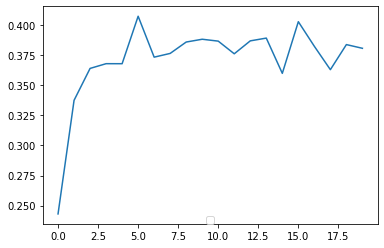

In [18]:
# plot the f scores
%matplotlib inline
import matplotlib.pyplot as plt

def plot_history(fscores):
    print("History:", fscores)
    print("Highest f-score:", max(fscores))
    plt.plot(fscores)
    plt.legend(loc='lower center', borderaxespad=0.)
    plt.show()

plot_history(evaluation_function.fscore)

## 1.2 Expand context

Modify your network in such way that it is able to utilize the surrounding context of the word. This can be done for instance with a convolutional or recurrent layer. Analyze different neural network architectures and hyperparameters. How does utilizing the surrounding context influence the predictions?


In [0]:
#expanding to RNN model with context

from keras.layers import LSTM

example_count, sequence_len = vectorized_data_padded.shape
class_count = len(label_set)
rnn_size = 100

vector_size= pretrained.shape[1]

def build_rnn_model(example_count, sequence_len, class_count, rnn_size, vocabulary, vector_size, pretrained):
    inp=Input(shape=(sequence_len,))
    embeddings=Embedding(len(vocabulary), vector_size, mask_zero=False, trainable=False, weights=[pretrained])(inp)
    rnn = LSTM(rnn_size, activation='sigmoid', return_sequences=True)(embeddings)
    outp=Dense(class_count, activation="softmax")(rnn)
    return Model(inputs=[inp], outputs=[outp])

rnn_model = build_rnn_model(example_count, sequence_len, class_count, rnn_size, vocabulary, vector_size, pretrained)

In [20]:

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 561)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 561, 300)          15000600  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 561, 100)          30100     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 561, 37)           3737      
Total params: 15,034,437
Trainable params: 33,837
Non-trainable params: 15,000,600
_________________________________________________________________
None


In [21]:

optimizer=Adam(lr=0.007) # define the learning rate
rnn_model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", sample_weight_mode='temporal')

evaluation_function=EvaluateEntities()

# train
rnn_hist=rnn_model.fit(vectorized_data_padded,vectorized_labels_padded, sample_weight=weights, batch_size=100,verbose=2,epochs=5, callbacks=[evaluation_function])

Epoch 1/5
 - 225s - loss: 0.0133

Precision/Recall/F-score: 0.5272015655577299 / 0.1460796009109641 / 0.22877038043478265
Epoch 2/5
 - 219s - loss: 0.0073

Precision/Recall/F-score: 0.5615915430920569 / 0.2765426743303329 / 0.3705946469662105
Epoch 3/5
 - 222s - loss: 0.0063

Precision/Recall/F-score: 0.5793166765033773 / 0.3193435274554459 / 0.41172632363907535
Epoch 4/5
 - 223s - loss: 0.0058

Precision/Recall/F-score: 0.5770592674290358 / 0.3593608791526588 / 0.442904878592114
Epoch 5/5
 - 224s - loss: 0.0055

Precision/Recall/F-score: 0.5915234822451317 / 0.3733506850305462 / 0.457770981539348


No handles with labels found to put in legend.


History: [0.22877038043478265, 0.3705946469662105, 0.41172632363907535, 0.442904878592114, 0.457770981539348]
Highest f-score: 0.457770981539348


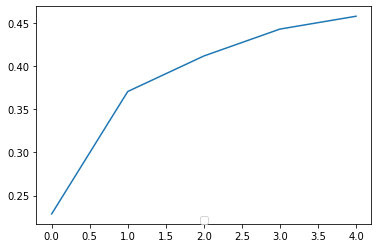

In [22]:

%matplotlib inline

plot_history(evaluation_function.fscore)

## 2.1 Use deep contextual representations

Use deep contextual representations. Fine-tune the embeddings with different hyperparameters. Try different models (e.g. cased and uncased, multilingual BERT). Report your results.


In [0]:

# Maximum number of examples to read
MAX_EXAMPLES = 1000

# Maximum length of input sequence in tokens
INPUT_LENGTH = 250

# Number of epochs to train for
EPOCHS = 3

# Optimizer learning rate
LEARNING_RATE = 0.00002

# Training batch size
BATCH_SIZE = 8

In [24]:
!pip3 install keras-bert

  Created wheel for keras-bert: filename=keras_bert-0.81.0-cp36-none-any.whl size=37913 sha256=2fb414918da911c449ab33fa2864cd1c42c50bf5433efb4073aca49540d2e431
  Stored in directory: /root/.cache/pip/wheels/bd/27/da/ffc2d573aa48b87440ec4f98bc7c992e3a2d899edb2d22ef9e
  Created wheel for keras-transformer: filename=keras_transformer-0.33.0-cp36-none-any.whl size=13260 sha256=50974af1da2088b9e9f181a6233646fd3896b20298f8b9a3a909780bc633e915
  Stored in directory: /root/.cache/pip/wheels/26/98/13/a28402939e1d48edd8704e6b02f223795af4a706815f4bf6d8
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-cp36-none-any.whl size=7554 sha256=fd0efe4c0865537835ced63c05d555a547659579e51597859fe97b5b2f75d98c
  Stored in directory: /root/.cache/pip/wheels/5b/a1/a0/ce6b1d49ba1a9a76f592e70cf297b05c96bc9f418146761032
  Created wheel for keras-multi-head: filename=keras_multi_head-0.22.0-cp36-none-any.whl size=15371 sha256=f9245f28f958133623ff21b36f33c5aac52298be2d8be9fa84ce35a6e3d0d1af
  Stor

In [0]:
import os


os.environ['TF_KERAS'] = '1'    # Required to use tensorflow.python.keras with keras-bert

In [26]:
#preprocess data
if len(train_data) > MAX_EXAMPLES:
    print('Note: truncating examples from {} to {}'.format(len(train_data), MAX_EXAMPLES))
    train_data = train_data[:MAX_EXAMPLES]

# Look at the data
print(type(train_data))
print(type(train_data[0]))
print(train_data[0].keys())
print(train_data[0])

Note: truncating examples from 30000 to 1000
<class 'list'>
<class 'dict'>
dict_keys(['text', 'tags'])
{'text': ['Sharon', 'Repudiates', 'the', 'Road', 'Map', '.'], 'tags': ['O', 'O', 'O', 'O', 'O', 'O']}


In [27]:
texts = [example['text'] for example in train_data]
labels = [example['tags'] for example in train_data]

# Example text and label
print('Text:', texts[0])
print('Label:', labels[0])

Text: ['Sharon', 'Repudiates', 'the', 'Road', 'Map', '.']
Label: ['O', 'O', 'O', 'O', 'O', 'O']


In [28]:
#download pretrained bert model
# Give -nc (--no-clobber) argument so that the file isn't downloaded multiple times 
!wget -nc https://storage.googleapis.com/bert_models/2018_10_18/cased_L-12_H-768_A-12.zip

--2020-05-10 16:52:04--  https://storage.googleapis.com/bert_models/2018_10_18/cased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 2607:f8b0:400e:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 404261442 (386M) [application/zip]
Saving to: ‘cased_L-12_H-768_A-12.zip’

cased_L-12_H-768_A- 100%[===================>] 385.53M   160MB/s    in 2.4s    

2020-05-10 16:52:06 (160 MB/s) - ‘cased_L-12_H-768_A-12.zip’ saved [404261442/404261442]



In [29]:

# Give -n argument so that existing files aren't overwritten 
!unzip -n cased_L-12_H-768_A-12.zip


Archive:  cased_L-12_H-768_A-12.zip
   creating: cased_L-12_H-768_A-12/
  inflating: cased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: cased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: cased_L-12_H-768_A-12/vocab.txt  
  inflating: cased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: cased_L-12_H-768_A-12/bert_config.json  


In [0]:

bert_vocab_path = 'cased_L-12_H-768_A-12/vocab.txt'
bert_config_path = 'cased_L-12_H-768_A-12/bert_config.json'
bert_checkpoint_path = 'cased_L-12_H-768_A-12/bert_model.ckpt'    # suffixes not required

In [0]:
model_is_cased = True


In [32]:

vocab = []
with open(bert_vocab_path) as f:
    for i, line in enumerate(f):
        vocab.append(line.rstrip('\n'))    # rstrip to remove newline characters


# Print a list with every 500th vocabulary item
print(vocab[0::500])

['[PAD]', 'щ', '吉', 'told', 'space', 'operations', 'proposed', 'Oxford', 'showing', 'domestic', 'mountains', 'commission', 'voices', 'associate', 'hills', 'Guide', 'relaxed', 'Page', 'Heights', 'singers', 'Interior', 'considers', 'facilitate', 'shouting', '1826', 'constitute', 'alter', 'clip', 'Into', 'Memory', 'ballad', 'Owens', 'Langdon', 'aquatic', 'stereo', 'Cass', 'Shock', '195', '##tec', '##sonic', 'attested', '##rdes', '1840s', '##90', 'Guys', '##rien', 'Munro', 'Ursula', 'mesh', 'diplomacy', 'Newmarket', '##oughs', 'synthesizers', 'Drugs', 'monstrous', '##ynamic', 'troll', '##ٹ']


In [33]:
from pprint import pprint    # pretty-printer for output
import json

with open(bert_config_path) as f:
    config = json.load(f)


# Print configuration contents
pprint(config)

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 28996}


In [34]:

# Create mapping from vocabulary items to their indices in the vocabulary
token_dict = { v: i for i, v in enumerate(vocab) }


# Print some random examples of the mapping
pprint(dict(random.choices(list(token_dict.items()), k=10)))

{'##bor': 12207,
 '##utile': 26555,
 'However': 1438,
 'Title': 11772,
 'calcium': 15355,
 'celebrities': 13073,
 'compares': 26153,
 'dome': 10945,
 'tap': 12999,
 'threatens': 18241}


In [35]:

from keras_bert import Tokenizer


tokenizer = Tokenizer(token_dict, cased=model_is_cased)


#Let's test that out
for s in ['Hello BERT!', 'Unknown: 你']:
    print('Original string:', s)
    print('Tokenized:', tokenizer.tokenize(s))
    indices, segments = tokenizer.encode(s, max_len=20)    # max_len for padding and truncation
    print('Encoded:', indices)
    print('Segments:', segments)
    print('Decoded:', ' '.join(tokenizer.decode(indices)))
    print()

Original string: Hello BERT!
Tokenized: ['[CLS]', 'Hello', 'B', '##ER', '##T', '!', '[SEP]']
Encoded: [101, 8667, 139, 9637, 1942, 106, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Segments: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded: Hello B ##ER ##T !

Original string: Unknown: 你
Tokenized: ['[CLS]', 'Unknown', ':', '你', '[SEP]']
Encoded: [101, 16285, 131, 100, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Segments: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded: Unknown : [UNK]



In [0]:
labels_flattened = []    #make list of lists into one list
for i in labels:
  for j in i:
    labels_flattened. append(j)

In [0]:
texts_flattened = []
texts[0][0]+' '+texts[0][1]
for i in texts:
  try:
    texts_flattened.append(auxi)
  except:
      pass
  #helper = []
  auxi = ''
  for j in i:
    auxi = auxi + str(j) + ' '


In [72]:
texts_flattened[0]

'Sharon Repudiates the Road Map . '

In [73]:
import numpy as np


token_indices, segment_ids = [], []
for text in texts_flattened:
    # tokenizer.encode() returns a sequence of token indices
    # and a sequence of segment IDs. BERT expects both as input,
    # even if the segments IDs are just all zeros (like here).
    tid, sid = tokenizer.encode(text, max_len=INPUT_LENGTH)
    token_indices.append(tid)
    segment_ids.append(sid)

# Format input as list of two numpy arrays
X = [np.array(token_indices), np.array(segment_ids)]


# Print some examples
print('Token indices:')
print(X[0][:2])
print('Decoded:')
for i in X[0][:2]:
    print(tokenizer.decode(list(i)))
print('Segment ids:')
print(X[1][:2])

Token indices:
[[  101 10562 20777 17294  5430  1103  1914 21824   119   102     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0    

In [0]:
#load pretrained bert model
from keras_bert import load_trained_model_from_checkpoint


pretrained_model = load_trained_model_from_checkpoint(
    config_file = bert_config_path,
    checkpoint_file = bert_checkpoint_path,
    training = False,
    trainable = True,
    seq_len = INPUT_LENGTH
)


In [75]:

# model.outputs is a list, here with a single item. We'll
# add our output layer on top of that.
bert_out = pretrained_model.outputs[0]

print(bert_out)

Tensor("Encoder-12-FeedForward-Norm_1/Identity:0", shape=(None, 250, 768), dtype=float32)


In [0]:
num_labels = len(label_set)

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TimeDistributed, Dense


out = TimeDistributed(Dense(num_labels, activation='softmax'))(bert_out)
model = Model(
    inputs=pretrained_model.inputs,
    outputs=[out]
)

In [0]:
#create optimizer

from keras_bert import calc_train_steps, AdamWarmup


# Calculate the number of steps for warmup
total_steps, warmup_steps = calc_train_steps(
    num_example=len(sentences_train),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    warmup_proportion=0.1,
)

optimizer = AdamWarmup(
    total_steps,
    warmup_steps,
    lr=LEARNING_RATE,
    epsilon=1e-6,
    weight_decay=0.01,
    weight_decay_pattern=['embeddings', 'kernel', 'W1', 'W2', 'Wk', 'Wq', 'Wv', 'Wo']
)

In [0]:
#evaluation metric
from tensorflow.python.keras import backend as K


def label_categorical_accuracy(y_true, y_pred):
    # Map one-hot targets and predictions to tag indices 
    y_true_idx = o.argmax(y_true, axis=-1)
    y_pred_idx = o.argmax(y_pred, axis=-1)
    # Compare targets to predicted elementwise and cast the
    # resulting boolean values to floating point values.
    # (K.floatx() returns current default float type.)
    correct_preds = o.cast(o.equal(y_true_idx, y_pred_idx), K.floatx())
    # Compare targets to the special NO_LABEL value and cast
    # the resulting boolean values to floating point values.
    # This gives a value of zero for NO_LABEL and one for others.
    is_label = o.cast(o.not_equal(y_true_idx, tag_to_int[NO_LABEL]), K.floatx())
    # Take elementwise product of the comparisons, giving values that
    # are one if the prediction is equal to the target and the target
    # is not the NO_LABEL value, and zero otherwise.
    correct_label_preds = o.multiply(correct_preds, is_label)
    # Accuracy is then the number of correct predictions for labels
    # divided by the number of labels.
    return o.reduce_sum(correct_label_preds)/o.reduce_sum(is_label)

In [0]:
#train model

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

In [87]:
history = model.fit(
    X,
    Y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1
)

Epoch 1/3


InvalidArgumentError: ignored

## 2.2 Error analysis

Select one model from each of the previous milestones (three models in total). Look at the entities these models predict. Analyze the errors made. Are there any patterns? How do the errors one model makes differ from those made by another?

## 3.1 Predictions on unannotated text

Use the three models selected in milestone 2.2 to do predictions on the sampled wikipedia text.

## 3.2 Statistically analyze the results

Statistically analyze (i.e. count the number of instances) and compare the predictions. You can, for example, analyze if some models tend to predict more entities starting with a capital letter, or if some models predict more entities for some specific classes than others.